In [25]:
# let's draw what we are working with
from gstools import SRF, Gaussian
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

x = y = range(100)
model = Gaussian(dim=3, var=0.1, len_scale=10)
srf = SRF(model, seed=20170519)
#field = srf.structured([x, y, 0])
#srf.plot()
num_steps = 20
frames = [srf.structured([x,y,i]) for i in range(num_steps)]


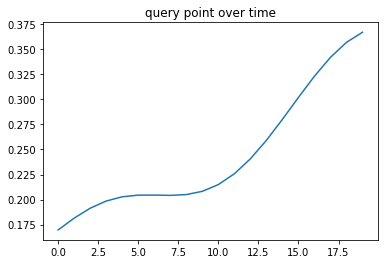

In [26]:
# visualize the query point
import numpy as np
frames= np.array(frames)#.reshape(100,100,-1)
ts = frames[:,50,50]
plt.title('query point over time')
plt.plot(ts)

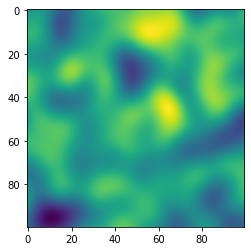

In [27]:
plt.imshow(frames[19])

<ipython-input-28-d2f54a4acfa8>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pts = np.array(pts).T[:2].T.tolist()


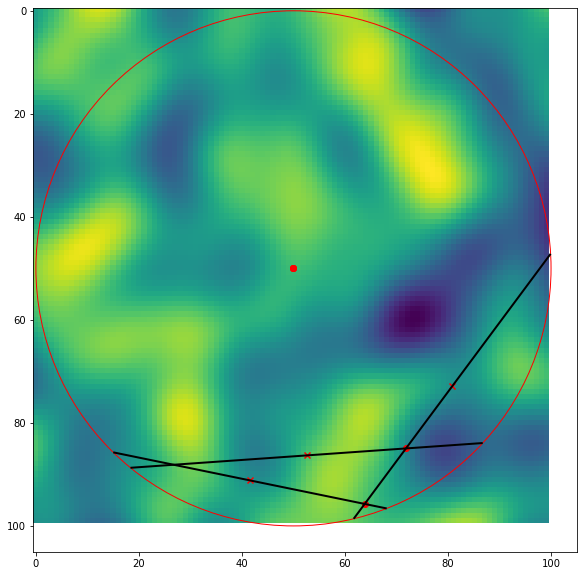

In [28]:
from matplotlib.path import Path
import matplotlib.patches as patches
import math
from copy import copy
# create list of measurement lines
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(frames[0])
codes = [
    Path.MOVETO,
    Path.LINETO,]
c = plt.Circle((50, 50), 50, color='r',fill=False)
ax.add_patch(c)

# generating sequence of 

def circle_points(rad):
    angle1 = np.random.uniform(0,2*math.pi)
    angle2 = np.random.uniform(0,2*math.pi)
    x1 = [ rad*np.cos(angle1)+50, rad*np.sin(angle1)  +50]
    x2 = [ rad*np.cos(angle2)+50, rad*np.sin(angle2)  +50 ]

    return x1, x2,angle1,angle2

# needs the previous angles
def circle_points_next(rad, angle1_p, angle2_p):
    if angle1_p < angle2_p:
        # swap them
        temp = angle2_p
        angle2_p = angle1_p
        angle1_p = temp
    angle1 = np.random.uniform(angle2_p,angle1_p)
    angle2 = np.random.uniform( angle1_p-2*math.pi , angle2_p)
    x1 = [ rad*np.cos(angle1)+50, rad*np.sin(angle1)  +50]
    x2 = [ rad*np.cos(angle2)+50, rad*np.sin(angle2)  +50 ]

    return x1, x2,angle1,angle2

# sequence of 20 points
pts = [circle_points(50)]
while len(pts)<20:
    pts.append( circle_points_next(50,pts[-1][2], pts[-1][3] )) 
pts = np.array(pts).T[:2].T.tolist()
#print(pts.shape)

chords = []
for pt in pts:
    path = Path(pt, codes)
    patch = patches.PathPatch(path, facecolor='orange', lw=2)
    chords.append(copy(patch))


for i in range(3):
    path = Path([pts[i][0],pts[i][1]], codes)
    patch = patches.PathPatch(path, facecolor='orange', lw=2)
    ax.add_patch(patch)
    plt.scatter([50],[50],c='r')


def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C
# get intersection between two lines
def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    x = Dx / D
    y = Dy / D
    return x,y

# the two things we might use for a reconstructionn

# closest point on the chord to the query point; always the midpoint
close_pt = []
for pt in pts:
    closest_pt = np.array(pt[0])/2 + np.array(pt[1])/2
    close_pt.append(closest_pt.tolist())

# the point of crossover between the chords
cx_pt = []
for i in range(len(pts)-1):
    l1 = np.array([pts[i][0],pts[i][1] ])
    l2 = np.array([pts[i+1][0],pts[i+1][1] ])
    cx_pt.append( intersection(line(l1[0],l1[1]),line(l2[0],l2[1])) )

close_pt = np.array(close_pt)
cx_pt = np.array(cx_pt)
plt.scatter(close_pt[:3,0], close_pt[:3,1], c='r', marker='x')
plt.scatter(cx_pt[:2,0], cx_pt[:2,1], c='r', marker='o')



In [29]:
ntimes = len(close_pt)
times = np.linspace(0,num_steps, ntimes-1)

close_sample = [srf.structured([close_pt[i][0],close_pt[i][1],times[i]])[0][0][0] for i in range(len(times))]

cx_sample = [srf.structured([cx_pt[i][0],cx_pt[i][1],times[i]])[0][0][0] for i in range(len(times))]

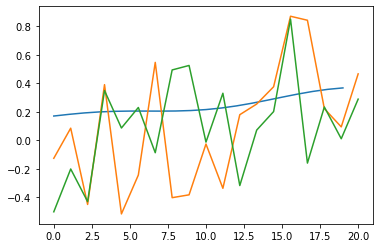

In [30]:
t= np.linspace(0, len(frames), 100)

ts = frames[:,50,50]
plt.title('query point over time')
plt.cla()
plt.plot(ts)
plt.plot(times, cx_sample)
plt.plot(times, close_sample)

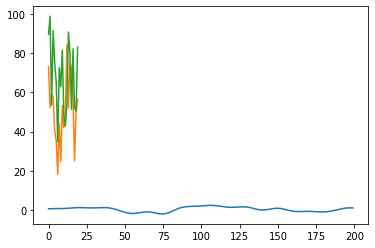

animating!


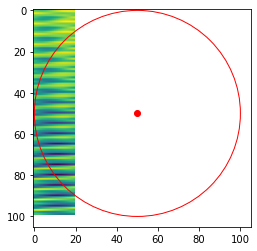

In [16]:

def animate_srf(frames, chords, saveto):
    fig, ax = plt.subplots()
    xdata, ydata = [], []
    ln, = ax.plot([], [], 'ro')

    chord_times = np.linspace(0,len(frames), len(chords))

    def init():
        #grid = srf.structured([x, y, 0])
        ax.imshow(frames[0])
        c = plt.Circle((50, 50), 50, color='r',fill=False)
        ax.add_patch(c)
        ax.add_patch(chords[0])
        ax.scatter([50],[50],c='r')
        return ln,

    def update(frame):
        plt.cla()
        #grid=srf.structured([x, y, frames[gr]])
        #plt.scatter([50],[50],'rx')
        ax.imshow(frames[frame])
        c = plt.Circle((50, 50), 50, color='r',fill=False)
        ax.add_patch(c)
        ax.scatter([50],[50],c='r')
        #k=0
        #while frame>=chord_times[k]:
        #    k+=1
        #ax.add_patch(chords[0])
        return ln,
    
    print('animating!')
    ani = FuncAnimation(fig, update, frames=list(range(len(frames))), init_func=init, blit=True)
    ani.save(saveto, writer='pillow', fps=60)

animate_srf(frames,chords,saveto='toy2.gif')
